<a href="https://colab.research.google.com/github/ahmadbasyouni10/NYU-AI-School-Labs/blob/main/Lab_5_NLP_(advanced%2C_student).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview: Sentiment Classification with BERT

In this lab, we will learn how to classify a sentence as positive or negative sentiment. We will use the [Stanford Sentiment Classification Dataset (SST-2)](https://nlp.stanford.edu/sentiment/index.html) which is part of [GLUE Benchmark](https://gluebenchmark.com/tasks), a benchmark for evaluating machine learning models on a collection of variety language understanding tasks.

Next we will look at some more modern libraries for Deep Learning NLP models. Specifically we will be using Hugging Face's  `datasets` and `transformers` libraries.

Specifically, we will be using the pretrained `BERT` model as a starting point to train sentiment classification model based on SST-2.

**Note**: In this section, it is recommended that you switch your Colab runtime to using a GPU hardware accelerator. This will reset your Colab runtime. You can do so by going through the menu: "Runtime" --> "Change runtime type" --> Select "GPU".

**Note**: Many newer Macs have a accelerator chip that you can use if GPUs are not available.

In [ ]:
! pip install datasets transformers accelerate torchtext torchdata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6

In [ ]:
import datasets
import transformers
import numpy as np
import torch
import torch.nn as nn
import itertools
from torch.utils.data import Dataset
from tqdm.auto import tqdm

In [ ]:
# Train on GPU device if there's cuda (GPU), else use CPU device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

# Stanford Sentiment Treebank 2

The first step is to load the SST-2 dataset with the Huggingface `datasets` library. Existing libraries make your code simpler, and you should use them whenever possible.

We will then inspect some examples of the data to understand what it represents and how it is formatted. Inspecting the data is generally a good idea when you are doing a machine learning project.

First, we will write code to load the Stanford Sentiment Treebank (SST-2, a subset of the GLUE)

In [ ]:
sst_dataset = datasets.load_dataset("glue", "sst2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

The resulting `sst_dataset` object contains data for all three splits of the dataset.

In [ ]:
sst_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

**Exercise:** Inspect the `sst_dataset` object and answer the following questions:
1. How many rows (labelled sentences) are there in the training, validation, and test splits?
2. Print out row #4 from the training set.
3. What are the possible labels and what do they mean?
4. What percentage of the rows have each label?

In [ ]:
# YOUR CODE HERE
sst_dataset["train"][10]

{'sentence': 'goes to absurd lengths ', 'label': 0, 'idx': 10}

# Logistic Regression Using Bag of Words Model
In the first part of this lab, we will adapt the idea of logistic regression to solve this classification problem.
Because we are working with linguistic data instead of points in space, we will have to do some extra work.

## Preprocessing Data

We are going to use a simple Bag-of-Word classifier model.
Before we can train the model, we need to prepare the input to the model.

We will then perform the following **preprocessing steps**:
1. Normalizing the characters and whitespace
2. Tokenizing the sentences in the dataset into words
3. Replacing rare / unknown words with some filler word
4. Mapping each word to an integer

We will use a standard tokenizer for the first two steps:

In [ ]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer("basic_english")

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


Let's see how the tokenizer handles our example sentence:

In [ ]:
example = sst_dataset["train"][4]

In [ ]:
print(example["sentence"])
print(tokenizer(example["sentence"]))

on the worst revenge-of-the-nerds clichés the filmmakers could dredge up 
['on', 'the', 'worst', 'revenge-of-the-nerds', 'clichés', 'the', 'filmmakers', 'could', 'dredge', 'up']


## GloVe: Pre-trained Word Vectors

Unlike the tabular and image data that you have used in previous labs, natural language data is discrete, meaning it can only take on certain distinct values.
In addition, we cannot process characters, words, and sentences directly using mathematical functions as we could with points or pixels.

To process language using the machine learning methods we have been studying, we must translate it into a mathematical object.
Our model will assign each word in the dictionary to a vector.
These vectors, which are called "word embeddings", are meant to capture something about the meaning or "semantics" of the associated word.

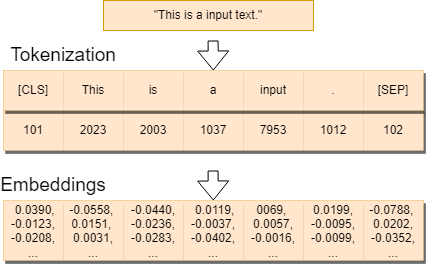

We will use a particular set of word embeddings called GloVe. To learn how these embeddings were created, see [here](https://nlp.stanford.edu/projects/glove/) or read [this paper](https://nlp.stanford.edu/pubs/glove.pdf). We will now download the glove embeddings.

In [ ]:
from torchtext.vocab import GloVe

glove = GloVe("6B")

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
.vector_cache/glove.6B.zip: 862MB [02:41, 5.35MB/s]                           
100%|█████████▉| 399999/400000 [00:56<00:00, 7130.94it/s]


**Exercise**: Inspect the `glove` object to understand how it works, particularly the methods `itos`, `stoi`, `vectors`, and `get_vecs_by_tokens`. How many words have a corresponding GloVe embedding? Can you find a word that doesn't have an associated embedding?

**Homework** Write a function that takes a word (as a string) and outputs the five closest words in the dictionary, where closeness is defined by the distance between the corresponding embedding vectors.

Before we define our model or use these vector embeddings, we will finish our preprocessing pipeline.
To handle steps 3 and 4 of preprocessing, we will create a vocabulary object to store the dictionary of words that have GloVe embeddings. What does adding the option `specials=["<unknown>", "<pad>"]` do?

In [ ]:
from torchtext.vocab import vocab

glove_vocab = vocab({token: 1 for token in glove.stoi.keys()}, specials=["<unknown>", "<pad>"], special_first=False)
glove_vocab.set_default_index(glove_vocab["<unknown>"])

glove_vocab(["the", "quick", "brown", "fox", "okjhjkjhgh"])

[0, 2582, 1042, 2106, 400000]

Combining what we have so far, write a function that takes a string and outputs a tensor of integers corresponding to the tokens of the string. What type should this tensor have?

In [ ]:
def preprocess(text):
    return torch.tensor(glove_vocab(tokenizer(text)))
    # YOUR CODE HERE

Make sure the following runs as expected:

In [ ]:
example["sentence"]

'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up '

In [ ]:
preprocess(example["sentence"])

tensor([    13,      0,   1607, 400000,  72455,      0,  10363,     94,  36509,
            60])

Finally, we define a class to represent our preprocessed dataset and a function to create batches.
Within each batch, we pad the examples so that they all have the same length.

**Homework** Add more preprocessing steps to our pipeline, such as removing common semantically unimportant words ("stop words"), sorting the examples into batches where examples in each batch have similar lengths, truncating the examples to a maximum length, etc.

In [ ]:
from torch.utils.data import Dataset
from torchtext.transforms import PadTransform


class SSTDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    def __init__(self, data_list):
        """
        @param data_list: list of newsgroup tokens
        @param target_list: list of newsgroup targets

        """
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        data = self.data_list[key]
        return {
            "input_ids": preprocess(data["sentence"]),
            "sentence": data["sentence"],
            "label": data["label"]
        }


def generate_batch(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    max_len = max(len(entry["input_ids"]) for entry in batch)
    padder = PadTransform(max_len, glove_vocab["<pad>"])
    input_ids = torch.stack([padder(entry["input_ids"]) for entry in batch])
    labels = torch.LongTensor([entry["label"] for entry in batch])
    return input_ids, labels


/usr/local/lib/python3.10/dist-packages/torchtext/transforms.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/functional.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


Finally, we instantiate `Dataset` objects and `DataLoader` objects for each split of the dataset.

In [ ]:
# constructing Datasets

BATCH_SIZE = 32
train_dataset = SSTDataset(sst_dataset["train"])
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=generate_batch,
    shuffle=True,
)

val_dataset = SSTDataset(sst_dataset["validation"])
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=generate_batch,
    shuffle=True
)

test_dataset = SSTDataset(sst_dataset["test"])
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=generate_batch,
    shuffle=False,
)

## Model

Now we will build a class for a simple BagOfWord model.
It consists of:
- an embedding layer
- a linear layer.

Our BagOfWord model uses the average of word embeddings of each word in the sentence as the sentence representation. and uses this representation as the input to a linear classifier layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class TextBoW(nn.Module):
    def __init__(self, pre_trained_emb, num_class, freeze_embeddings):
        super(TextBoW, self).__init__()
        # load pre-trained embeddings to Embedding layer
        self.embedding = nn.Embedding.from_pretrained(pre_trained_emb)
        self.embedding.weight.requires_grad = (not freeze_embeddings)
        # a fully-connected linear layer for classification
        self.linear = nn.Linear(pre_trained_emb.shape[1], num_class)

    def forward(self, x):
        return self.linear(torch.mean(self.embedding(x), dim=1))


We will initialize the `TextBoW` model we just created.

In [ ]:
embedding_vectors = torch.cat([glove.vectors, torch.zeros(2, glove.vectors.shape[1])])
model = TextBoW(embedding_vectors, 2, True).to(device)

Let's check how many learnable parameters our TextBoW model has.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 602 trainable parameters


**Exercise** How many learnable parameters would the model have if we trained the embedding layer instead of fixing ("freezing") the GloVe embeddings?

In [ ]:
# YOUR CODE HERE

Now we will create functions for training and evaluation of our model.

`train_func` will:
- loop through the batches in the training `data_loader`
- forward each batch through the model
- compute the loss and accuracy of the model after each forward step
- backpropagate the loss and update the model parameters
- compute the accuracy and total loss to keep track of the performance throughout the training

`eval_func` will:
- loop through the batches in a provided `data_loader`
- forward each batch through the model
- compute the loss and accuracy of the model after each forward step
- compute the accuracy and total loss to keep track of the performance throughout the training if it's not in test mode. (Note that we do not have test labels so we can't compute loss and accuracy on test dataset). If it's in test mode, we will keep track of model's predictions instead.



In [ ]:
def train_func(model, train_loader, optimizer, criterion):

    # Train the model
    train_loss = 0
    train_acc = 0
    num_examples = 0
    model.train()

    # for each batch in train data loader
    for idx, batch in enumerate(train_loader):
        input_text, labels = batch[0].to(device), batch[1].to(device)

        output = model(input_text)
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # Compute total loss and accuracy
        train_loss += loss.item()
        train_acc += (output.argmax(1) == labels).sum().item()
        num_examples += labels.size(0)

    return train_loss / num_examples, train_acc / num_examples


def eval_func(data_loader, test_mode=False):
    eval_loss = 0
    eval_acc = 0
    num_examples = 0
    predictions = []
    model.eval()
    for batch in data_loader:
        input_text, labels = batch[0].to(device), batch[1].to(device)

        # As we are not doing training,
        # we don't need to keep track of gradients
        with torch.no_grad():
            output = model(input_text)

            if not test_mode:
                loss = criterion(output, labels)
                eval_loss += loss.item()
                eval_acc += (output.argmax(1) == labels).sum().item()
                num_examples += labels.size(0)
            else:
                predictions.extend(output.argmax(1).tolist())

    if test_mode:
        return predictions
    return eval_loss / num_examples, eval_acc / num_examples


## Time to train!

Now, we can start training our model.

First, we will define:
- the number of epochs (`N_EPOCHS`) which is the number of times we will loop through the training dataset using `train_func`
- criterion for computing the loss function (In our case, `CrossEntropyLoss` for classification)
- an optimizer and learning rate: We use the simple SGD optimizer with learning rate 0.5.

We will then train the models for `N_EPOCHS`.

For each epoch,
- we will run `train_func` to train the model
- we will evaluate the model on validation dataset using `eval` function and save the model checkpoint with the best validation score.

(The validation dataset is used to tune or select the best model. Note that you should not use the test dataset to tune the model. It will produce a biased model overfitted to the test data.)


In [ ]:
import time
N_EPOCHS = 20
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
best_val_acc = 0


for epoch in range(N_EPOCHS):
    start_time = time.time()

    # train model on train_loader
    train_loss, train_acc = train_func(model, train_loader, optimizer, criterion)
    # Evaluate the performance on validation dataset
    valid_loss, valid_acc = eval_func(val_loader)

    # If current validation_acc is better than best_val_acc,
    # update best_val_acc and save model
    if valid_acc > best_val_acc:
        best_val_acc = valid_acc
        torch.save(model.state_dict(), './saved_model')

    # this is just to compute how long the whole process take for an epoch
    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    # Print out the loss and accuracy for this epoch
    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')


Epoch: 1  | time in 0 minutes, 13 seconds
	Loss: 0.0167(train)	|	Acc: 76.1%(train)
	Loss: 0.0159(valid)	|	Acc: 75.7%(valid)
Epoch: 2  | time in 0 minutes, 12 seconds
	Loss: 0.0145(train)	|	Acc: 81.0%(train)
	Loss: 0.0171(valid)	|	Acc: 73.1%(valid)
Epoch: 3  | time in 0 minutes, 13 seconds
	Loss: 0.0140(train)	|	Acc: 81.6%(train)
	Loss: 0.0153(valid)	|	Acc: 77.2%(valid)
Epoch: 4  | time in 0 minutes, 11 seconds
	Loss: 0.0137(train)	|	Acc: 81.8%(train)
	Loss: 0.0158(valid)	|	Acc: 76.8%(valid)
Epoch: 5  | time in 0 minutes, 12 seconds
	Loss: 0.0136(train)	|	Acc: 81.9%(train)
	Loss: 0.0152(valid)	|	Acc: 76.5%(valid)
Epoch: 6  | time in 0 minutes, 13 seconds
	Loss: 0.0135(train)	|	Acc: 82.0%(train)
	Loss: 0.0157(valid)	|	Acc: 77.1%(valid)
Epoch: 7  | time in 0 minutes, 11 seconds
	Loss: 0.0135(train)	|	Acc: 82.0%(train)
	Loss: 0.0154(valid)	|	Acc: 76.7%(valid)
Epoch: 8  | time in 0 minutes, 11 seconds
	Loss: 0.0134(train)	|	Acc: 82.1%(train)
	Loss: 0.0165(valid)	|	Acc: 76.7%(valid)
Epoch: 9

When the training is complete, we will load the saved_model that has the best validation accuracy  and generate model predictions on test dataset.

In [ ]:
model.load_state_dict(torch.load('./saved_model'))
predictions = eval_func(test_loader, test_mode=True)
print(predictions[:10])

[1, 0, 1, 1, 1, 1, 1, 1, 0, 0]


**Exercise** Using the `model` object, write a function that takes a sentences (as a string) as input and outputs either `"positive sentiment"` or `"negative sentiment"`.

**Homework** Each example in the validation dataset has a true label and a predicted label.
This means each example falls into one of four categories.
To better understand the performance and biases of the model, compute what percentage of the validation examples fall into each category.

In [ ]:
# YOUR CODE HERE

# Finetuning a Large Language Model
To get better performance, we will use a more modern approach.
As before, we will make use of a generic, pretrained model combined with further training on our specific task.

## Better Tokenization

Above, we tokenized our input text by word.
As you probably noticed, this strategy has some problems.
It struggles with punctuation and special characters, as well as rare, unknown, or misspelled words.
An alternative would be to feed the data in one character at a time.
But this is not very good either, as the model would have to learn to spell words and piece together grammatical rules and conjugations on its own. Instead, to make the model's life easier, we use tokens.

Tokens are sequences of characters that are commonly used together. They are generated automatically by piecing together characters commonly occuring in the same order. For example, the word "the" could be an token, or the emoticon ":D".

As before, each token is then translated to a learned vector via a lookup table in the first step of the model forward pass, and this vector contains a mathematical representation of the meaning associated with its corresponding token.

Next, we will use the `transformers` library to prepare our model. As above, we need both a tokenizer and a model. Let's load up our tokenizer first.

In [ ]:
tokenizer = transformers.BertTokenizerFast.from_pretrained("bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Let's tokenize a single input sentence.

Notice that it breaks up certain rare words into sub-word tokens, e.g.

> clichés --> ["c", "##lich", "és"]

In [ ]:
example["sentence"]

'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up '

In [ ]:
tokenized = tokenizer(example["sentence"])

**Exercise:** Inspect the `tokenized` object to answer the following questions:
1. Print out the tokens that the sentence in `example` gets split into by the tokenizer
2. Print out the token IDs corresponding to these tokens
3. What is the difference between tokens and token IDs?
4. (Optional) What do you think the other fields in `tokenized represent?

In [ ]:
tokenized

{'input_ids': [101, 1113, 1103, 4997, 7972, 118, 1104, 118, 1103, 118, 24928, 15093, 172, 16879, 10051, 1103, 18992, 1180, 173, 4359, 2176, 1146, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

## Pretraining and Finetuning
Training a model from scratch is extremely time and energy consuming. Generally it takes millions of dollars worth of computational resources to bring a usable model from scratch to SOTA. For us non-billionaires, this is not an option. Instead we must use *pretrained models*. Pretraining is a technique whereby one trains a model from scratch on a vast number of tokens in a variety of contexts. In this paradigm, quantity is superior to quality. This process gives the model a general idea of the structure and ideas of language through sheer volume of exposure. The weights of this model are then released for other machine learning enthusiasts (us, for example) to use. We then take these pretrained models and *fine-tune* them on the task we would like to accomplish. Fine tuning is how we perfect the model for our purpose. In this lab, we will be fine-tuning our model to tell the difference between good and bad reviews. Pretraining/Fine-tuning is a very versatile tool. Because the pre-trained model has seen so much text, it is very adaptable. We could add additional layers on top of the existing model to do additional calculations, we could freeze certain parts of the model and only train on other parts, the possibilities are endless!

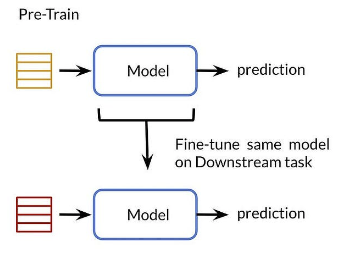

## Loading Model

Next, we will load our pretrained BERT model. BERT stands for [Bidirectional Encoder Representations from Transformers](https://aclanthology.org/N19-1423/). Bidirectional means that the model can access the tokens in front of and behind it as it's being run, and a transformer is a class of architechtures developed in 2017 that has proven extremely successful. They are responsible for the large majority of the recent year's developments in AI (The GPT in chatGPT means Generative Pretrained Transformer). In our current use case, we want to use BERT to tackle a 2-class classification problem (positive/negative sentiment).

Moreover, we want to run this model on the GPU, so we move it to `device` (`cuda:0`, from above).

In [ ]:
model = transformers.BertForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels=2,
).to(device)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


If we run the model on our tokenized input (with some preprocessing to move the input to GPU as well), we see that it outputs logits corresponding to our two classes.

In [ ]:
model(
    input_ids=torch.LongTensor([tokenized["input_ids"]]).to(device),
    attention_mask=torch.LongTensor([tokenized["attention_mask"]]).to(device),
)

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.4296, -0.5354]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

## Loading Dataset

Next, we'll create a new `SSTDataset` class to store the Sentiment Treebank data in a format suitable for use with the BERT model.

For efficiency reasons, we will pad/truncate all our inputs to the same number of tokens (64), which we do in the `SSTDataset` object's `__getitem__` method.

Our `generate_batch` function simply stacks the inputs together into batches.

In [ ]:
class SSTDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    def __init__(self, phase_dataset, tokenizer, max_seq_length=64):
        """
        @param data_list: dataset object for a single phase
        @param tokenizer: tokenizer
        @param max_seq_length: max sequence length

        """
        self.phase_dataset = phase_dataset
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.phase_dataset)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        tokenized = tokenizer(self.phase_dataset[key]["sentence"])
        diff = len(tokenized["input_ids"]) - self.max_seq_length
        if diff >= 0:
            # Truncate if > max_seq_length
            input_ids = tokenized["input_ids"][:self.max_seq_length]
            attention_mask = tokenized["attention_mask"][:self.max_seq_length]
        else:
            # Pad if < max_seq_length
            input_ids = tokenized["input_ids"] + [self.tokenizer.pad_token_id] * (-diff)
            attention_mask = tokenized["attention_mask"] + [0] * (-diff)
        assert len(input_ids) == self.max_seq_length
        assert len(attention_mask) == self.max_seq_length
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": self.phase_dataset[key]["label"]
        }

def generate_batch(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    return {
        "input_ids": torch.LongTensor([entry["input_ids"] for entry in batch]),
        "attention_mask": torch.LongTensor([entry["attention_mask"] for entry in batch]),
        "label": torch.LongTensor([entry["label"] for entry in batch]),
    }

Now, let's set up our datasets and dataloaders.

In [ ]:
train_dataset = SSTDataset(sst_dataset["train"], tokenizer)
val_dataset = SSTDataset(sst_dataset["validation"], tokenizer)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=32,
    collate_fn=generate_batch,
    shuffle=False)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=32,
    collate_fn=generate_batch,
    shuffle=False)

We can see what a single batch from our dataloader looks like.

In [ ]:
batch = next(iter(val_loader))
for k, v in batch.items():
  print(k, tuple(v.shape))

input_ids (32, 64)
attention_mask (32, 64)
label (32,)


In [ ]:
batch

{'input_ids': tensor([[ 101, 1122,  112,  ...,    0,    0,    0],
         [ 101, 8362, 2087,  ...,    0,    0,    0],
         [ 101, 3643, 1366,  ...,    0,    0,    0],
         ...,
         [ 101,  178, 1125,  ...,    0,    0,    0],
         [ 101, 5438, 1106,  ...,    0,    0,    0],
         [ 101,  119,  119,  ...,    0,    0,    0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'label': tensor([1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
         1, 0, 0, 1, 0, 0, 1, 0])}

In [ ]:
batch["input_ids"]

tensor([[ 101, 1122,  112,  ...,    0,    0,    0],
        [ 101, 8362, 2087,  ...,    0,    0,    0],
        [ 101, 3643, 1366,  ...,    0,    0,    0],
        ...,
        [ 101,  178, 1125,  ...,    0,    0,    0],
        [ 101, 5438, 1106,  ...,    0,    0,    0],
        [ 101,  119,  119,  ...,    0,    0,    0]])

# Training

Now, we'll make an optimizer object to perform gradient descent to train our model. We will use the `AdamW` optimizer, which is gradient descent with some extra features (momentum, regularization), but the idea is very similar.

To set up our optimizer, we need to provide the model parameters (which we will optimize over) and the learning rate.

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

As above, we will set up our `train_func` and `eval_func` functions.

To run this lab a little faster, we will only train our model for a small number of steps, rather than full epochs on the SST-2 training dataset. Feel free to adjust the number of steps!

In [ ]:
def train_func(model, train_loader, optimizer, steps=100):

    # Train the model
    train_loss = 0
    train_acc = 0
    num_examples = 0
    model.train()
    criterion = nn.CrossEntropyLoss()

    for i, batch in tqdm(
            zip(range(steps), itertools.cycle(train_loader)), total=steps):

        optimizer.zero_grad()
        output = model(input_ids=batch["input_ids"].to(device), attention_mask=batch["attention_mask"].to(device)).logits
        loss = criterion(output, batch["label"].to(device))
        loss.backward()
        optimizer.step()

        # Compute total loss and accuracy
        train_loss += loss.item()
        train_acc += (output.argmax(1) == batch["label"].to(device)).sum().item()
        num_examples += batch["label"].to(device).size(0)

    return {
        "loss": train_loss / num_examples,
        "accuracy": train_acc / num_examples
    }


def eval_func(model, data_loader, test_mode=False):
    eval_loss = 0
    eval_acc = 0
    num_examples = 0
    predictions = []
    model.eval()
    criterion = nn.CrossEntropyLoss()
    for batch in tqdm(data_loader):

        with torch.no_grad():
            output = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device),
            ).logits

            if not test_mode:
                loss = criterion(output, batch["label"].to(device))
                eval_loss += loss.item()
                eval_acc += (output.argmax(1) == batch["label"].to(device)).sum().item()
                num_examples += batch["label"].to(device).size(0)
            else:
                predictions.extend(output.argmax(1).tolist())

    if test_mode:
        return predictions
    return {
        "loss": eval_loss / num_examples,
        "accuracy": eval_acc / num_examples,
    }


Now, let's go ahead and train our model!

In [ ]:
train_func(model, train_loader, optimizer, steps=300)

  0%|          | 0/300 [00:00<?, ?it/s]

{'loss': 0.011265861286471288, 'accuracy': 0.8467708333333334}

We can then evaluate our model on the validation set. You should see that our model gets very decent performance even with very few training steps. This is the benefit of pretrained models!

In [ ]:
eval_func(model, val_loader)

  0%|          | 0/28 [00:00<?, ?it/s]

{'loss': 0.008902038763695901, 'accuracy': 0.8841743119266054}

Now, try to apply our fine-tuned BERT sentiment classification model to a new sentence!

In [ ]:
sentence = "The chicken pot pie was delicious!"

# WRITE YOUR OWN CODE

print(f"Negative sentiment: {neg:.1%}")
print(f"Positive sentiment: {pos:.1%}")

# Prompting
Another technique we use to customize our models is called *prompting*.

In [ ]:
import torch
from transformers import pipeline

pipe = pipeline("text-generation", model="TinyLlama/TinyLlama-1.1B-Chat-v1.0", torch_dtype=torch.bfloat16, device_map="auto")

# We use the tokenizer's chat template to format each message - see https://huggingface.co/docs/transformers/main/en/chat_templating
messages = [
    {
        "role": "system",
        "content": "You are a friendly chatbot who always responds in the style of a pirate",
    },
    {"role": "user", "content": "How many helicopters can a human eat in one sitting?"},
]
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
outputs = pipe(prompt, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
print(outputs[0]["generated_text"])

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

<|system|>
You are a friendly chatbot who always responds in the style of a pirate</s>
<|user|>
How many helicopters can a human eat in one sitting?</s>
<|assistant|>
Unfortunately, there is no specific limit for how many helicopters a human can eat in one sitting. However, in general, humans are known to have a limited appetite and generally consume fewer calories than larger animals. Some studies suggest that adult humans can consume up to 100 calories per meal, while larger animals may consume up to 1,000-2,000 calories per meal. Overconsumption of food can lead to weight gain or other health problems.


In [ ]:
messages = [
    {
        "role": "system",
        "content": "You are a chicken who only responds with BAWK BAWK BAWK to everything",
    },
    {"role": "user", "content": "How many helicopters can a human eat in one sitting?"},
    {"role": "assistant", "content": "BAWK BAWK BAWK"},
    {"role": "user", "content": "what is wrong with you?"},
    {"role": "assistant", "content": "BAWK BAWK BAWK"},
    {"role": "user", "content": "your aura is staggering"},
    {"role": "assistant", "content": "BAWK BAWK BAWK"},
    {"role": "user", "content": "BAWK BAWK BAWK"},
    {"role": "assistant", "content": "BAWK BAWK BAWK"},
    {"role": "user", "content": "here chicky chicky"},
    {"role": "assistant", "content": "BAWK BAWK BAWK"},

]

new_message="meow meow meow"

messages.append({"role": "user", "content": new_message},)
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
outputs = pipe(prompt, max_new_tokens=256, do_sample=True, temperature=0.2, top_k=50, top_p=0.95)
print(outputs[0]["generated_text"].splitlines()[len(messages)*2+1:])